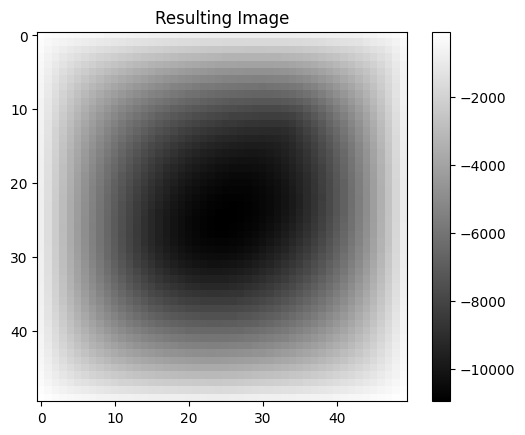

[[ -138.14534358  -223.17820787  -283.21332712 ...  -440.76488707
   -352.52009905  -211.67744721]
 [ -232.40314894  -395.35413319  -520.15430573 ...  -778.71018389
   -599.63802884  -350.18967095]
 [ -303.11308397  -533.68080828  -720.53737043 ... -1034.97059447
   -777.13210036  -443.44317854]
 ...
 [ -282.8808724   -527.06515253  -741.07030564 ...  -630.44047535
   -444.95696179  -236.23784279]
 [ -208.81231135  -382.37846317  -531.48898629 ...  -443.86340987
   -316.17403001  -169.53270324]
 [ -117.98993888  -210.14745025  -287.22141708 ...  -236.47919672
   -169.34303966   -94.71893644]] 0


In [15]:

#the second optimal method
import cv2 as op
import numpy as np
from scipy import ndimage
from scipy.sparse import spdiags
from scipy.sparse.linalg import bicgstab
import matplotlib.pyplot as plt

im=op.imread("imageonline.jpg")
#用于处理的灰度目标图像
gray=im[0:50,0:50,0]
gray_x=gray.shape[0]
gray_y=gray.shape[1]

#设置焦距
#f=10

#全一矩阵
one=np.ones((gray_x,gray_y))
gray_delete=gray-one

#把原来图像化成列向量
gray_column=gray_delete.reshape(-1,1)

#laplacian矩阵
L_2D=discrete_laplacian_2d_matrix(gray_x,gray_y)
#print(gray.shape)

#使用双共轭梯度稳定迭代法求解 Ax = b
p,exitcode=bicgstab(L_2D,gray_column,atol=1e-5)

p=p.reshape(gray_x,gray_y)

#输出检测
plt.imshow(p, cmap='gray')
plt.colorbar()
plt.title('Resulting Image')
plt.show()
print(p,exitcode)







def discrete_laplacian_2d_matrix(m, n):
    """
    生成一个m x n的二维离散拉普拉斯算子的系统矩阵。
    
    参数:
    m, n -- 矩阵的行和列的大小
    
    返回:
    L -- 二维离散拉普拉斯算子的系统矩阵
    """
    # 初始化矩阵
    L = np.zeros((m * n, m * n))
    
    # 遍历每个像素点
    for i in range(m):
        for j in range(n):
            idx = i * n + j  # 当前像素的索引
            # 计算拉普拉斯算子
            if i > 0:  # 上
                L[idx, idx - n] = 1
            if i < m - 1:  # 下
                L[idx, idx + n] = 1
            if j > 0:  # 左
                L[idx, idx - 1] = 1
            if j < n - 1:  # 右
                L[idx, idx + 1] = 1
            # 主对角线元素
            L[idx, idx] = -4
    
    return L








In [2]:
import numpy as np
# 创建一个5x5的矩阵
matrix_5x5 = np.arange(25).reshape(5, 5)

# 将矩阵变为列向量
column_vector = matrix_5x5.reshape(-1, 1)

# 输出结果
print("Original 5x5 matrix:\n", matrix_5x5)
print("\nColumn vector:\n", column_vector)

Original 5x5 matrix:
 [[ 0  1  2  3  4]
 [ 5  6  7  8  9]
 [10 11 12 13 14]
 [15 16 17 18 19]
 [20 21 22 23 24]]

Column vector:
 [[ 0]
 [ 1]
 [ 2]
 [ 3]
 [ 4]
 [ 5]
 [ 6]
 [ 7]
 [ 8]
 [ 9]
 [10]
 [11]
 [12]
 [13]
 [14]
 [15]
 [16]
 [17]
 [18]
 [19]
 [20]
 [21]
 [22]
 [23]
 [24]]
